# Modul 3 Andat : Script IOC
Pada script ini mencakup 6 visualisasi data,
1. Plot Time Series
2. Plot Power Spectral Density
3. Plot Overlay Filter 6 jam
4. Plot FFT
5. Plot Overlay Filter 30 Hari (Bonus)
6. Plot Anomali Muka air (Bonus)

Author : Salbi Faza Rinaldi (September, 2020)

In [1]:
#import Library
import pandas as pd
import numpy as np
from datetime import datetime
import scipy.fft as fft
from scipy import signal
import warnings
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Comic Sans MS']

warnings.filterwarnings("ignore")

## 1. Plot Time Series 
Plot ini digunakan untuk melihat variasi muka air di suatu lokasi

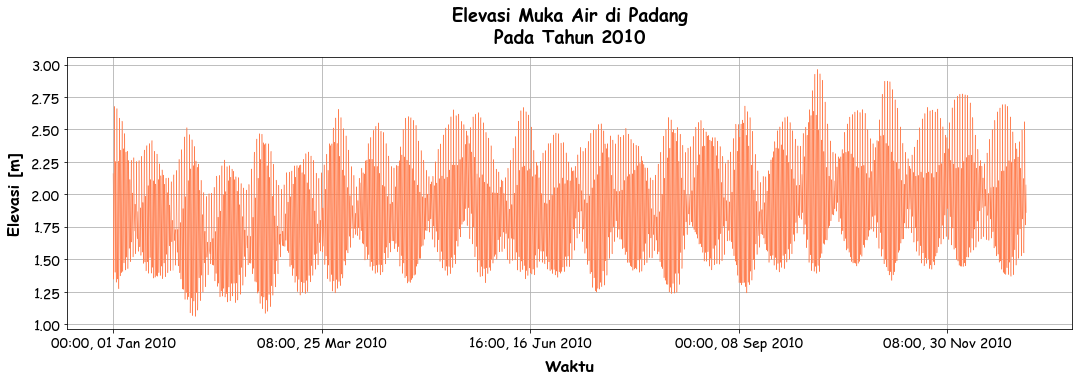

In [2]:
lokasi = 'Padang' #[CHANGE HERE]
tahun = 2010 #[CHANGE HERE]
bulan = 10 #[CHANGE HERE]
tanggal = 15 #[CHANGE HERE]

header_data = ['tahun','bulan', 'tanggal','jam','elevasi_mm']
raw_data = pd.read_csv('h107.csv',names=header_data) #[CHANGE HERE]

data_tahun = raw_data[raw_data['tahun'] == tahun]
data_tahun['elevasi_m'] = data_tahun['elevasi_mm'].apply(lambda x: x/1000)
data_tahun['tanggal_lengkap'] = (data_tahun.tahun.astype(str)+'-'
                                    +data_tahun.bulan.astype(str)+'-'
                                    +data_tahun.tanggal.astype(str)+' '
                                    +data_tahun.jam.astype(str)+':00')
data_tahun['tanggal_lengkap'] = pd.to_datetime(data_tahun['tanggal_lengkap'])
data_tahun['tanggal_lengkap'] = data_tahun['tanggal_lengkap'].dt.strftime('%H:%M, %d %b %Y')
data_tahun = data_tahun.set_index(data_tahun['tanggal_lengkap'])

data_tahun.drop('elevasi_mm',axis=1,inplace=True)
data_tahun.drop('tanggal_lengkap',axis=1,inplace=True)

#Plot data
data_index = data_tahun.index[0:len(data_tahun.index):24*30*3]
data_nindex = np.arange(0,len(data_tahun.index),24*30*3)

data_tahun['elevasi_m'].plot(color='coral', lw=.5,figsize=(18,5))
plt.title('Elevasi Muka Air di '+ lokasi + '\nPada Tahun ' + 
          str(tahun), fontsize=18, weight='bold',pad=15)
plt.xlabel('Waktu', fontsize=16, fontweight='bold',labelpad=8)
plt.ylabel('Elevasi [m]', fontsize=16, fontweight='bold',labelpad=8)
# plt.xticks(data_nindex,data_index, fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()

#export gambar, berikan directory lokasi export
plt.savefig('Plot elevasi.png',dpi=300)

#show gambar tanpa export
plt.show()

## 2. Plot Power Spectral Density
plot ini digunakan untuk melihat frekuensi dominan pada sinyal time series

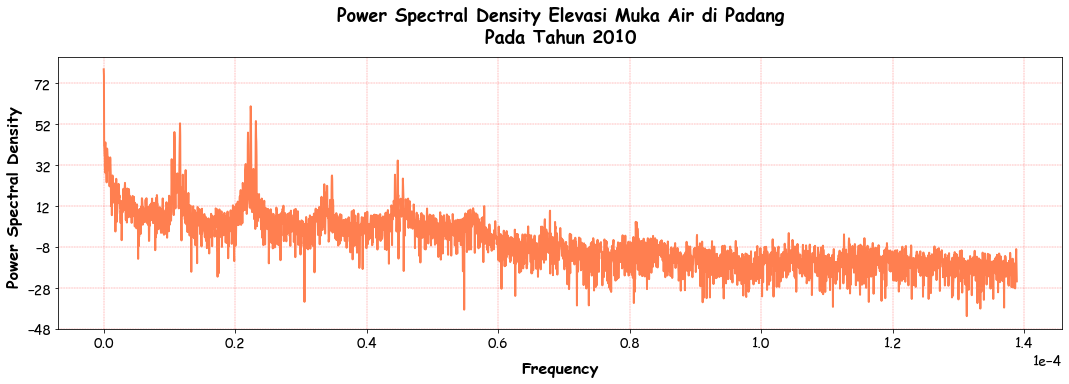

In [3]:
fig, ax = plt.subplots(figsize=(18,5))
ax.psd(data_tahun['elevasi_m'],NFFT=len(data_tahun),Fs=1/3600,color='coral',lw=2)
ax.set_title('Power Spectral Density Elevasi Muka Air di '+ lokasi + 
             '\nPada Tahun ' + str(tahun), fontsize=18, weight='bold',
            pad=15)
ax.set_xlabel('Frequency',fontsize=16, fontweight='bold', labelpad=10)
ax.set_ylabel('Power Spectral Density ',fontsize=16, fontweight='bold')
ax.ticklabel_format(axis='x',scilimits=(0,0))
tx = ax.xaxis.get_offset_text()
tx.set_fontsize(14)
ax.grid(color='r', ls = '-.', lw = 0.25)
ax.tick_params(axis='both', which='major', labelsize=14)


#export gambar, berikan directory lokasi export
# plt.savefig('...',dpi=300)

#show gambar tanpa export
plt.show()

## 3. Plot Overlay Filter 6 Jam
Plot ini digunakan untuk melihat elevasi muka air dalam 1 hari

In [4]:
Ts = 3600 # periode pengambilan data dalam sekon
Fs = 1/Ts  # Frekuensi sampling, satuan Hz

fc = 1/(Ts*6)  # Frekuensi cut-off = 1 hari, satuan 1/s atau Hz
w = fc / (Fs / 2) # Normalisasi frekuensi

b, a = signal.butter(5, w, 'low') # desain filter untuk 'low pass'
filter_6jam = signal.filtfilt(b, a, data_tahun['elevasi_m']) # implementasi filter ke data

data_tahun['filter_6jam'] = filter_6jam

data_tahun_bulan = data_tahun[data_tahun['bulan'] == bulan]
data_tahun_bulan_tanggal = data_tahun_bulan[data_tahun_bulan['tanggal'] == tanggal]
data = data_tahun_bulan['filter_6jam']

n = len(data) # Jumlah data

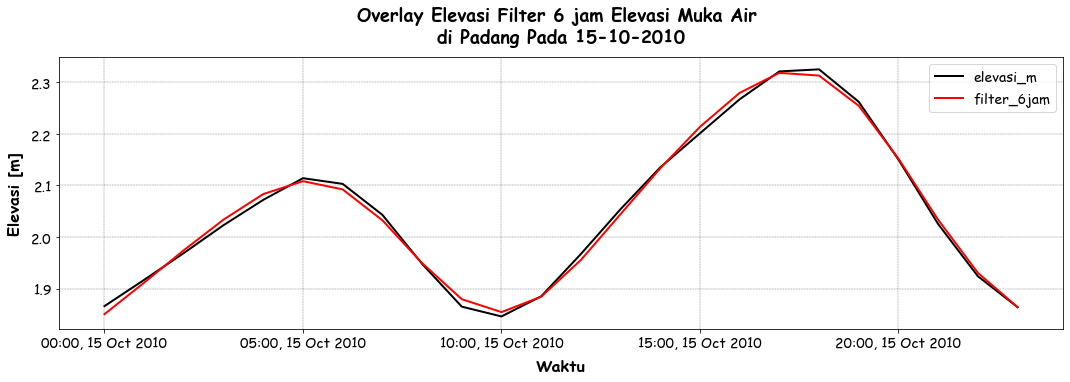

In [5]:
# Plot Data
data_index = data_tahun_bulan_tanggal.index[0:len(data_tahun_bulan_tanggal.index):7]
data_nindex = np.arange(0,len(data_tahun_bulan_tanggal.index),7)

data_tahun_bulan_tanggal['elevasi_m'].plot(color='black', lw=2, figsize=(18,5))
data_tahun_bulan_tanggal['filter_6jam'].plot(color='red', lw=2, figsize=(18,5))
plt.legend(loc='best',fontsize=14)
plt.title('Overlay Elevasi Filter 6 jam Elevasi Muka Air \ndi '+ lokasi + 
          ' Pada ' + str(tanggal) + '-' + str(bulan) + '-' + str(tahun), 
          fontsize=18, weight='bold',pad=15)
plt.xlabel('Waktu', fontsize=16, fontweight='bold',labelpad=8)
plt.ylabel('Elevasi [m]', fontsize=16, fontweight='bold',labelpad=8)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(color='k', ls = '-.', lw = 0.25)

#export gambar, berikan directory lokasi export
# plt.savefig('...',dpi=300)

#show gambar tanpa export
plt.show()

## 4. Plot FFT
plot ini digunakan untuk melihat data dalam domain periode dan frekuensi

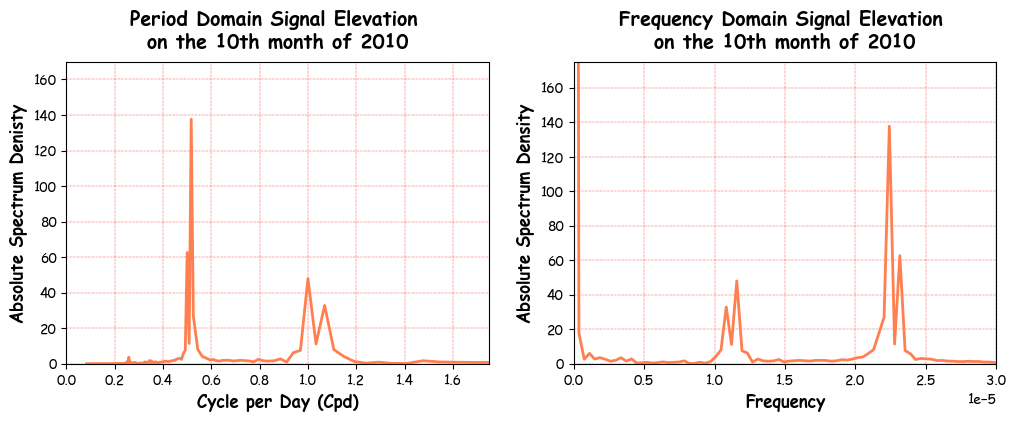

In [6]:
fft_elevasi = fft(data,n) # FFT data sst di kedalaman depth
fff_elevasi = fft_elevasi[0:round(n/2)] # Pemotongan Mirror Signal
xfft = Fs/n*np.arange(0,round(n/2))
pfft = (1/xfft)/(Ts*24) # Periode

# Plot data
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(12,4),dpi=100)
ax1.plot(pfft,abs(fff_elevasi), color = 'coral', lw = 2)
ax2.plot(xfft,abs(fff_elevasi), color = 'coral', lw = 2)

ax1.set_title('Period Domain Signal Elevation \non the ' + 
              str(bulan) + 'th month of ' + str(tahun), weight='bold',
              fontsize=14, pad=10)
ax1.set_xlabel('Cycle per Day (Cpd)', weight='bold',fontsize=12)
ax1.set_ylabel('Absolute Spectrum Denisty', weight='bold',fontsize=12)

ax2.set_title('Frequency Domain Signal Elevation \non the ' + 
              str(bulan) + 'th month of ' + str(tahun), weight='bold', 
              fontsize=14, pad=10)
ax2.set_xlabel('Frequency', weight='bold',fontsize=12)
ax2.set_ylabel('Absolute Spectrum Density', weight='bold',fontsize=12)

ax1.set(xlim=(0,1.75),ylim=(0,170))
ax2.set(xlim=(0,.3*10**(-4)),ylim=(0,175))
ax2.ticklabel_format(axis='x',scilimits=(0,0))

ax1.grid(color='r', ls = '-.', lw = 0.25)
ax2.grid(color='r', ls = '-.', lw = 0.25)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

#export gambar, berikan directory lokasi export
# plt.savefig('...',dpi=300)

#show gambar tanpa export
plt.show()

## 5 Plot Overlay Filter 30 Hari
Plot ini digunakan untuk melihat perbandingan filter 30 hari dengan raw data

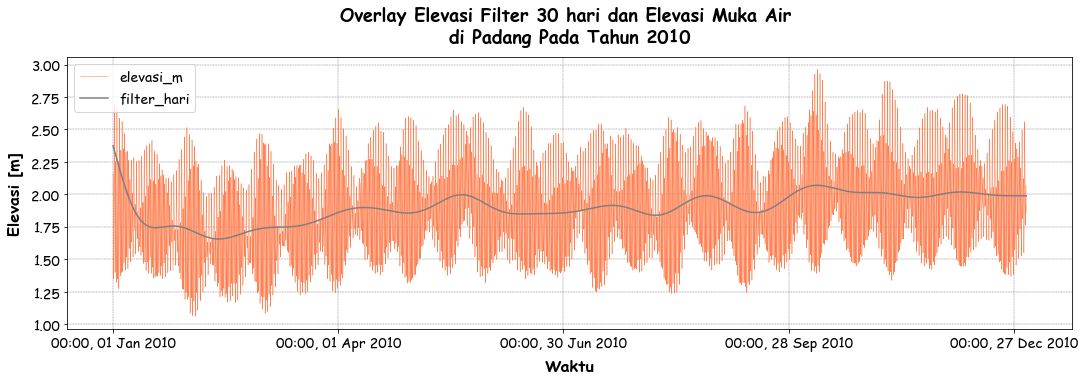

In [7]:
from scipy import signal

hari = 30 # Periode Cut-off
Ts = 3600 # periode pengambilan data dalam sekon
fs = 1/Ts  # Frekuensi sampling, satuan Hz

fc = 1/(Ts*24*hari)  # Frekuensi cut-off dalam hari, satuan 1/s atau Hz
w = fc / (fs / 2) # Normalisasi frekuensi

b, a = signal.butter(5, w, 'low') # desain filter untuk 'low pass'
filter_hari = signal.filtfilt(b, a, data_tahun['elevasi_m']) # implementasi filter ke data

data_tahun['filter_hari'] = filter_hari

# Plot Data
data_index = data_tahun.index[0:len(data_tahun.index):24*30*3]
data_nindex = np.arange(0,len(data_tahun.index),24*30*3)

data_tahun['elevasi_m'].plot(color='coral', lw=.5, figsize=(18,5))
data_tahun['filter_hari'].plot(color='grey', lw=1.5, figsize=(18,5))
plt.legend(loc='best',fontsize=14)
plt.title('Overlay Elevasi Filter '+str(hari) +' hari dan Elevasi Muka Air \ndi '+ lokasi + 
          ' Pada Tahun ' + str(tahun), fontsize=18, weight='bold',pad=15)
plt.xlabel('Waktu', fontsize=16, fontweight='bold',labelpad=8)
plt.ylabel('Elevasi [m]', fontsize=16, fontweight='bold',labelpad=8)
plt.xticks(data_nindex,data_index, fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(color='k', ls = '-.', lw = 0.25)

#export gambar, berikan directory lokasi export
# plt.savefig('...',dpi=300)

#show gambar tanpa export
plt.show()

## 6. Plot Anomali Muka Air 
plot ini digunakan untuk melihat anomali muka air dalam 1 tahun

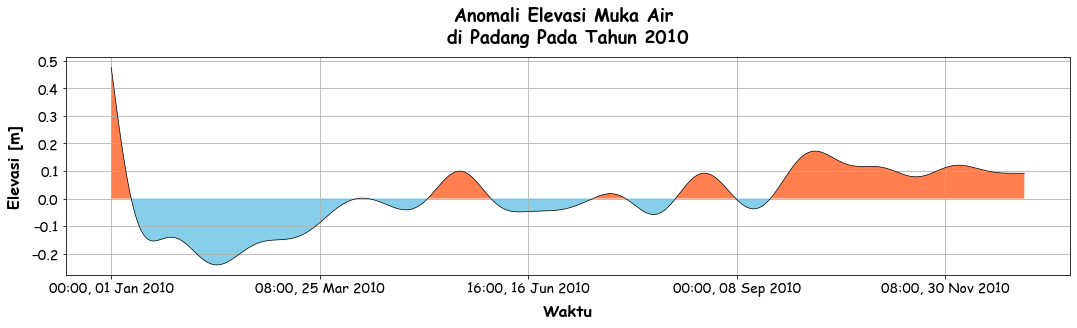

In [8]:
#Plot data
data_tahun['anomaly']=data_tahun['filter_hari']-data_tahun['filter_hari'].mean()
data_tahun['anomaly'].plot(figsize=(18,4),color='k',lw=.7)
plt.fill_between(data_tahun.index, 0, data_tahun['anomaly'], 
                 where= data_tahun['anomaly']<0, facecolor='skyblue', interpolate=True)
plt.fill_between(data_tahun.index, 0, data_tahun['anomaly'], 
                 where= data_tahun['anomaly']>0, facecolor='coral', interpolate=True)
plt.title('Anomali Elevasi Muka Air \ndi '+ lokasi + ' Pada Tahun ' + 
          str(tahun), fontsize=18, weight='bold',pad=15)
plt.xlabel('Waktu', fontsize=16, fontweight='bold', labelpad=8)
plt.ylabel('Elevasi [m]', fontsize=16, fontweight='bold', labelpad=8)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()

#export gambar, berikan directory lokasi export
# plt.savefig('...',dpi=300)

#show gambar tanpa export
plt.show()